<a href="https://colab.research.google.com/github/debashisdotchatterjee/VM-WG/blob/main/VM_WG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-2934790328.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(integrand, dx=dtheta)


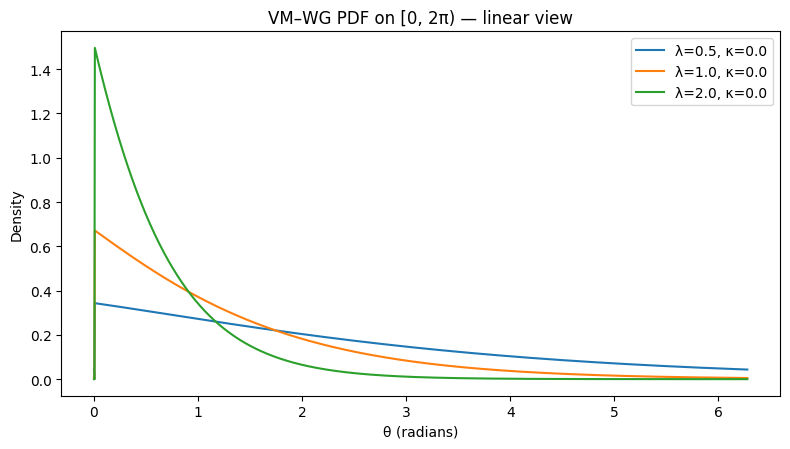

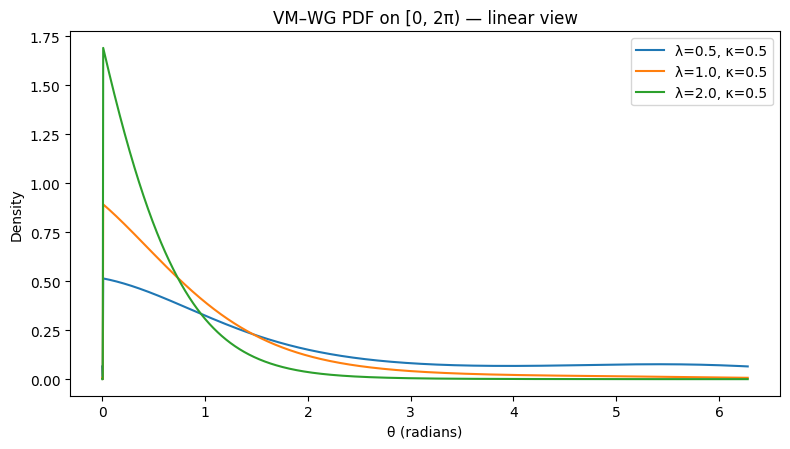

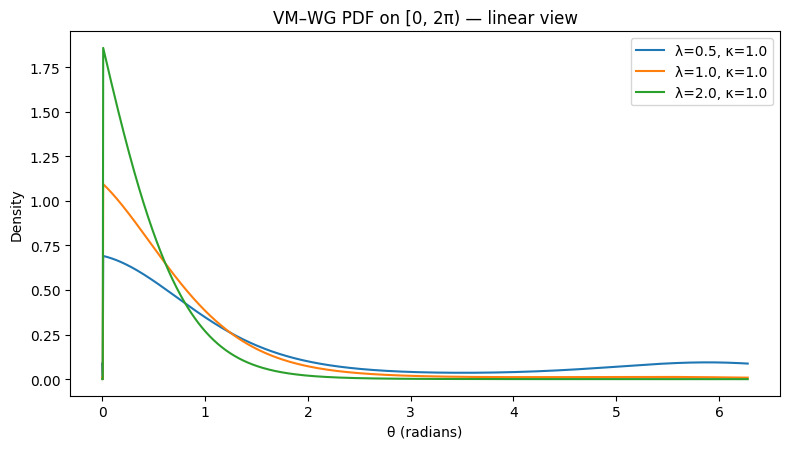

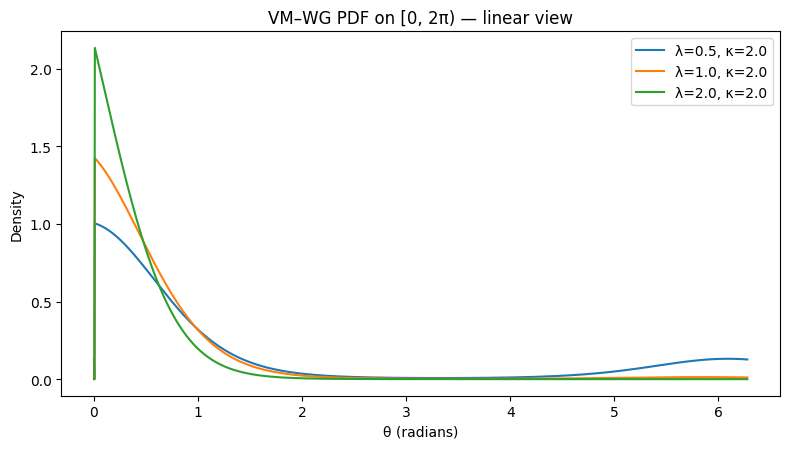

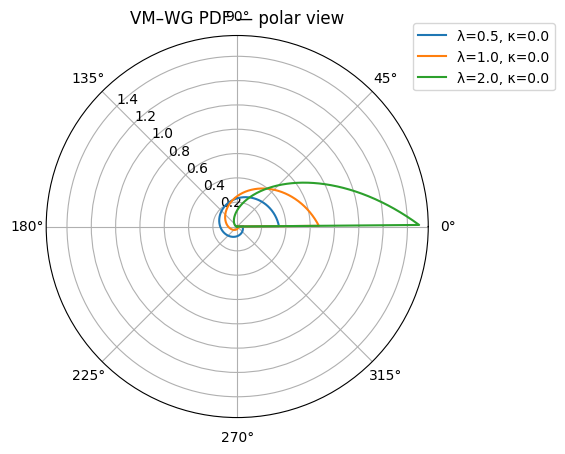

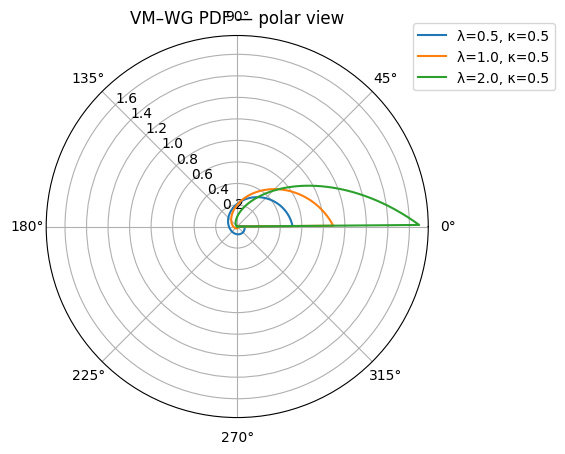

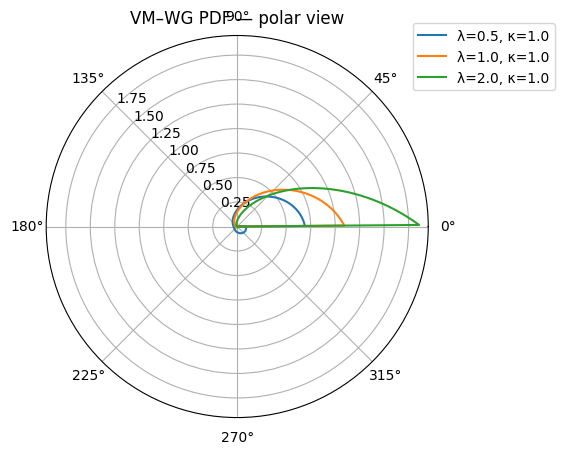

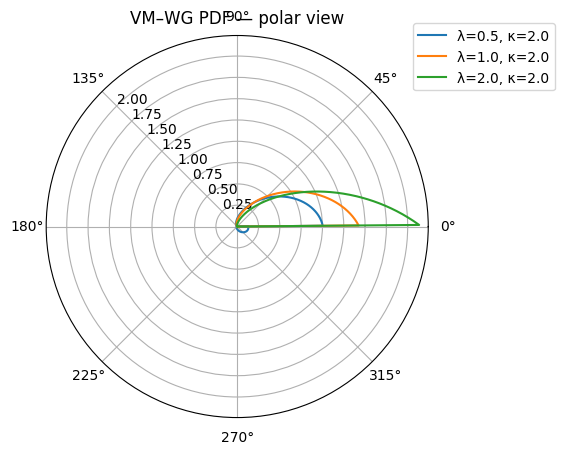

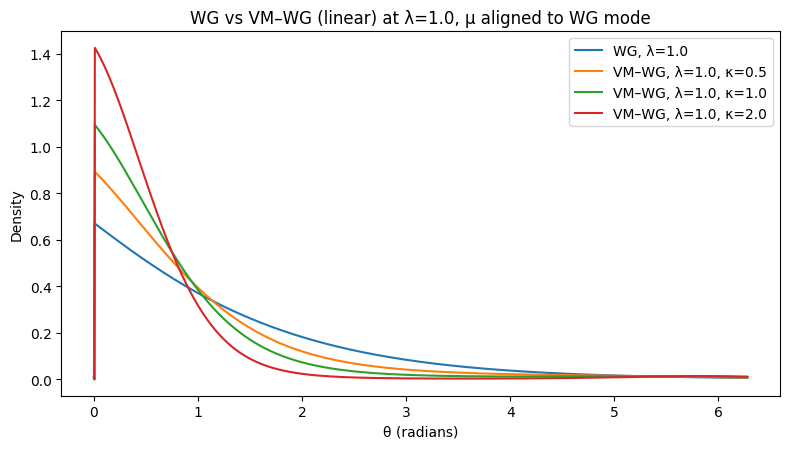

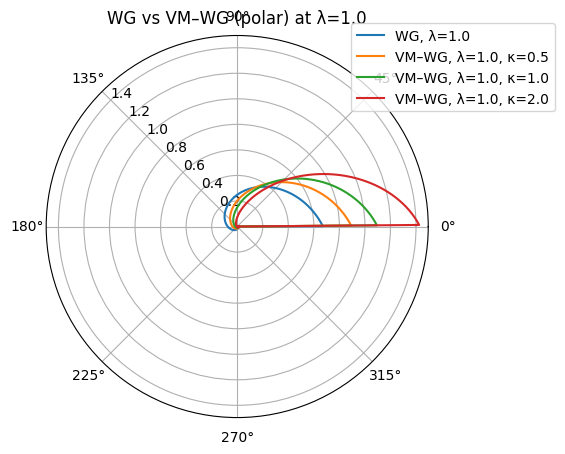

['vmwg_pdf_linear_kappa0.0.png',
 'vmwg_pdf_linear_kappa0.0.pdf',
 'vmwg_pdf_linear_kappa0.5.png',
 'vmwg_pdf_linear_kappa0.5.pdf',
 'vmwg_pdf_linear_kappa1.0.png',
 'vmwg_pdf_linear_kappa1.0.pdf',
 'vmwg_pdf_linear_kappa2.0.png',
 'vmwg_pdf_linear_kappa2.0.pdf',
 'vmwg_pdf_polar_kappa0.0.png',
 'vmwg_pdf_polar_kappa0.0.pdf',
 'vmwg_pdf_polar_kappa0.5.png',
 'vmwg_pdf_polar_kappa0.5.pdf',
 'vmwg_pdf_polar_kappa1.0.png',
 'vmwg_pdf_polar_kappa1.0.pdf',
 'vmwg_pdf_polar_kappa2.0.png',
 'vmwg_pdf_polar_kappa2.0.pdf',
 'compare_wg_vmwg_linear_lambda1.png',
 'compare_wg_vmwg_linear_lambda1.pdf']

In [4]:
# Re-run with safe axis labels (avoid \text in mathtext)
import numpy as np
import matplotlib.pyplot as plt

two_pi = 2.0 * np.pi

def wrap_angle(x):
    return x - two_pi * np.floor(x / two_pi)

def f_garima(x, lam):
    y = np.zeros_like(x, dtype=float)
    mask = x > 0
    y[mask] = (lam/(lam+2.0)) * (1.0 + lam + lam*x[mask]) * np.exp(-lam*x[mask])
    return y

def dWG(theta_vals, lam, tol=1e-12, M_max=500):
    theta_vals = wrap_angle(theta_vals)
    out = np.zeros_like(theta_vals, dtype=float)
    for i, th in enumerate(theta_vals):
        s = 0.0
        m = 0
        term = np.inf
        while m < M_max and (m == 0 or term > tol):
            t = th + two_pi*m
            term = f_garima(np.array([t]), lam)[0]
            s += term
            m += 1
        out[i] = s
    return out

def periodic_interp(x_grid, y_grid, xq):
    x_ext = np.concatenate([x_grid, np.array([two_pi])])
    y_ext = np.concatenate([y_grid, np.array([y_grid[0]])])
    xq_wrapped = wrap_angle(xq)
    return np.interp(xq_wrapped, x_ext, y_ext)

def vmwg_unnormalized(theta_grid, gWG_fun, lam, kappa, mu=0.0, delta=1, gWG_grid=None, use_interp=True):
    phi = wrap_angle(delta * (theta_grid - mu))
    if use_interp and gWG_grid is not None:
        g_phi = periodic_interp(theta_grid, gWG_grid, phi)
    else:
        g_phi = gWG_fun(phi, lam)
    return g_phi * np.exp(kappa * np.cos(theta_grid - mu))

def Z_numeric(theta_grid, gWG_grid, kappa):
    integrand = gWG_grid * np.exp(kappa * np.cos(theta_grid))
    dtheta = theta_grid[1] - theta_grid[0]
    return np.trapz(integrand, dx=dtheta)

lambdas = [0.5, 1.0, 2.0]
kappas = [0.0, 0.5, 1.0, 2.0]
delta = 1

N = 1440
theta = np.linspace(0.0, two_pi, N, endpoint=False)

gWG_by_lam = {}
mu_mode_by_lam = {}
for lam in lambdas:
    g = dWG(theta, lam)
    gWG_by_lam[lam] = g
    mu_mode_by_lam[lam] = theta[np.argmax(g)]

Z_by_lam_kappa = {}
for lam in lambdas:
    g = gWG_by_lam[lam]
    for kap in kappas:
        Z_by_lam_kappa[(lam, kap)] = Z_numeric(theta, g, kap)

files_generated = []

# Linear overlays per kappa
for kap in kappas:
    plt.figure(figsize=(8, 4.6))
    for lam in lambdas:
        g = gWG_by_lam[lam]
        mu_fit = mu_mode_by_lam[lam]
        num = vmwg_unnormalized(theta, dWG, lam, kap, mu=mu_fit, delta=delta, gWG_grid=g, use_interp=True)
        Z = Z_by_lam_kappa[(lam, kap)]
        dens = num / Z
        label = rf"λ={lam}, κ={kap}"
        plt.plot(theta, dens, label=label)
    plt.xlabel("θ (radians)")
    plt.ylabel("Density")
    plt.title("VM–WG PDF on [0, 2π) — linear view")
    plt.legend()
    plt.tight_layout()
    linear_png = f"vmwg_pdf_linear_kappa{kap}.png"
    linear_pdf = f"vmwg_pdf_linear_kappa{kap}.pdf"
    plt.savefig(linear_png, dpi=200, bbox_inches="tight")
    plt.savefig(linear_pdf, bbox_inches="tight")
    plt.show()
    plt.close()
    files_generated += [linear_png, linear_pdf]

# Polar overlays per kappa
for kap in kappas:
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, projection='polar')
    for lam in lambdas:
        g = gWG_by_lam[lam]
        mu_fit = mu_mode_by_lam[lam]
        num = vmwg_unnormalized(theta, dWG, lam, kap, mu=mu_fit, delta=delta, gWG_grid=g, use_interp=True)
        Z = Z_by_lam_kappa[(lam, kap)]
        dens = num / Z
        label = rf"λ={lam}, κ={kap}"
        ax.plot(theta, dens, label=label)
    ax.set_title("VM–WG PDF — polar view", va='bottom')
    ax.set_rlabel_position(135)
    ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.05))
    plt.tight_layout()
    polar_png = f"vmwg_pdf_polar_kappa{kap}.png"
    polar_pdf = f"vmwg_pdf_polar_kappa{kap}.pdf"
    plt.savefig(polar_png, dpi=200, bbox_inches="tight")
    plt.savefig(polar_pdf, bbox_inches="tight")
    plt.show()
    plt.close()
    files_generated += [polar_png, polar_pdf]

# Focused WG vs VM–WG comparison for λ=1.0
lam_demo = 1.0
g_demo = gWG_by_lam[lam_demo]
mu_demo = mu_mode_by_lam[lam_demo]

# Linear comparison
plt.figure(figsize=(8, 4.6))
plt.plot(theta, g_demo, label=f"WG, λ={lam_demo}")
for kap in [0.5, 1.0, 2.0]:
    num = vmwg_unnormalized(theta, dWG, lam_demo, kap, mu=mu_demo, delta=delta, gWG_grid=g_demo, use_interp=True)
    dens = num / Z_by_lam_kappa[(lam_demo, kap)]
    plt.plot(theta, dens, label=f"VM–WG, λ={lam_demo}, κ={kap}")
plt.xlabel("θ (radians)")
plt.ylabel("Density")
plt.title(f"WG vs VM–WG (linear) at λ={lam_demo}, μ aligned to WG mode")
plt.legend()
plt.tight_layout()
cmp_lin_png = "compare_wg_vmwg_linear_lambda1.png"
cmp_lin_pdf = "compare_wg_vmwg_linear_lambda1.pdf"
plt.savefig(cmp_lin_png, dpi=200, bbox_inches="tight")
plt.savefig(cmp_lin_pdf, bbox_inches="tight")
plt.show()
plt.close()
files_generated += [cmp_lin_png, cmp_lin_pdf]

# Polar comparison
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection='polar')
ax.plot(theta, g_demo, label=f"WG, λ={lam_demo}")
for kap in [0.5, 1.0, 2.0]:
    num = vmwg_unnormalized(theta, dWG, lam_demo, kap, mu=mu_demo, delta=delta, gWG_grid=g_demo, use_interp=True)
    dens = num / Z_by_lam_kappa[(lam_demo, kap)]
    ax.plot(theta, dens, label=f"VM–WG, λ={lam_demo}, κ={kap}")
ax.set_title(f"WG vs VM–WG (polar) at λ={lam_demo}", va='bottom')
ax.set_rlabel_position(135)
ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.05))
plt.tight_layout()
cmp_pol_png = "compare_wg_vmwg_polar_lambda1.png"
cmp_pol_pdf = "compare_wg_vmwg_polar_lambda1.pdf"
plt.savefig(cmp_pol_png, dpi=200, bbox_inches="tight")
plt.savefig(cmp_pol_pdf, bbox_inches="tight")
plt.show()
plt.close()
files_generated


/tmp/ipython-input-314204925.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(integrand, dx=dtheta)


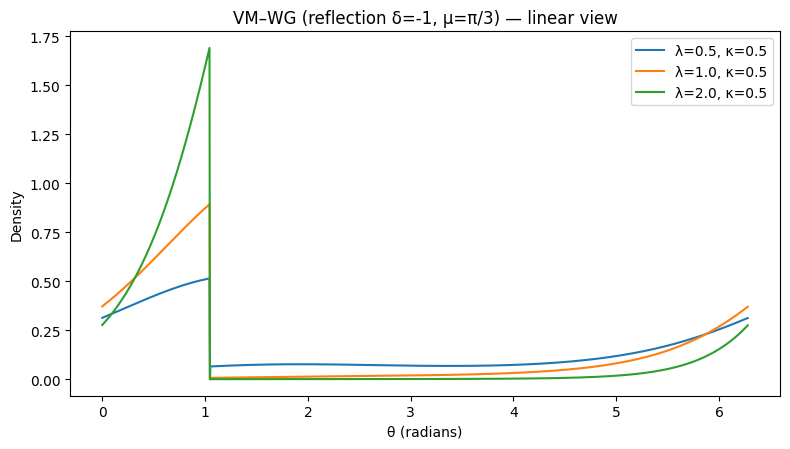

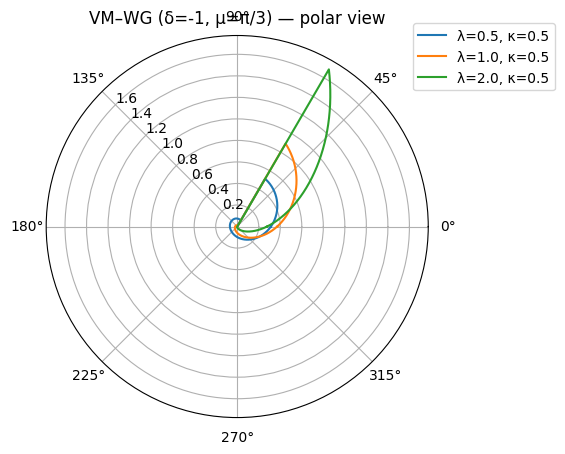

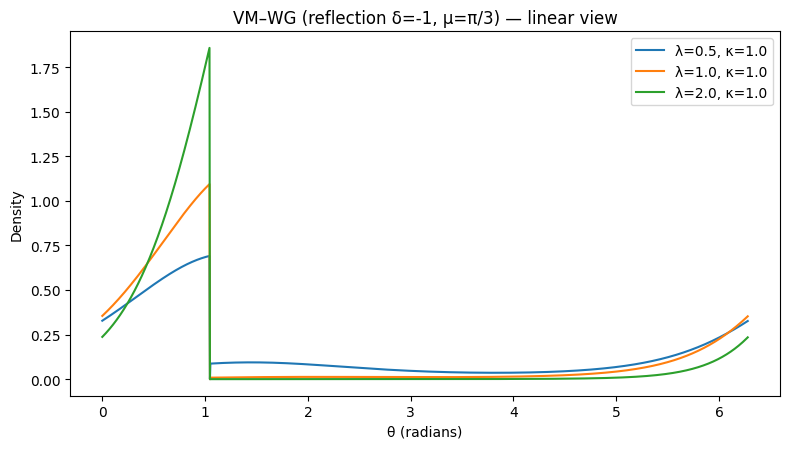

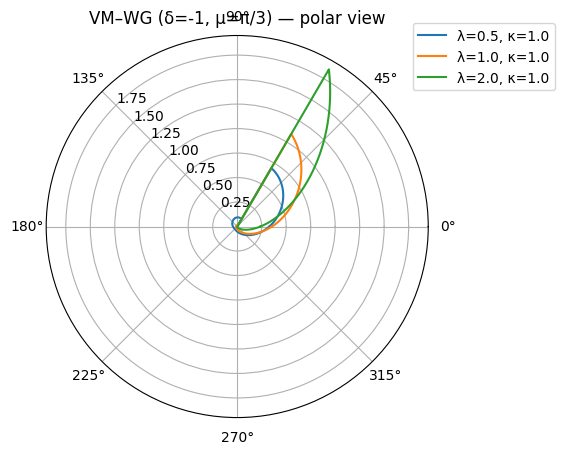

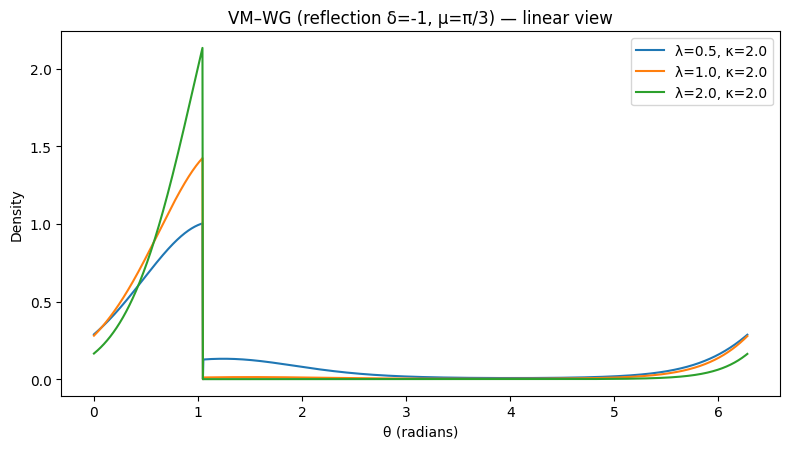

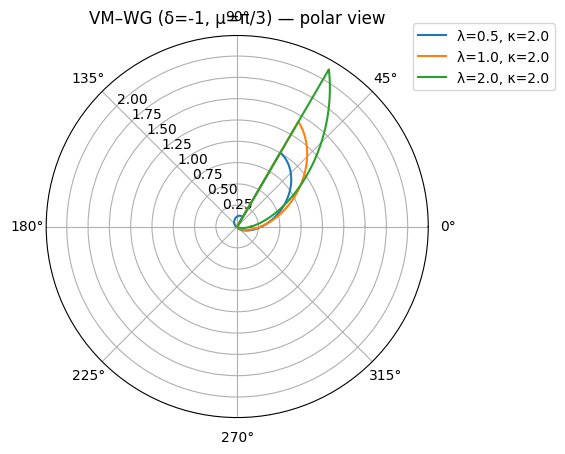

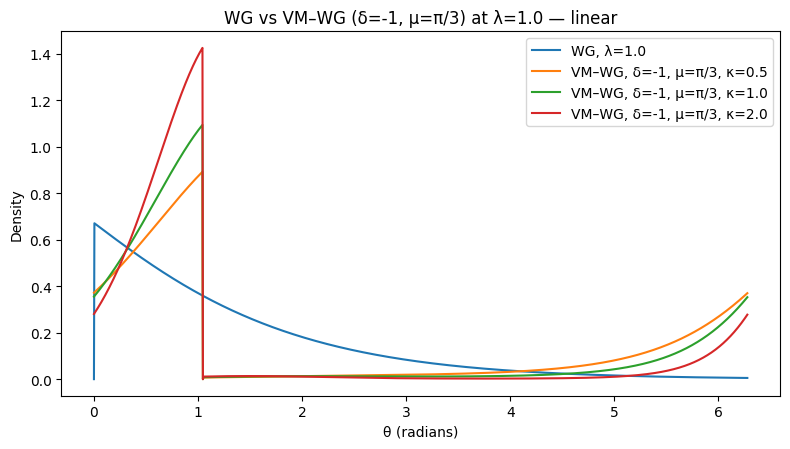

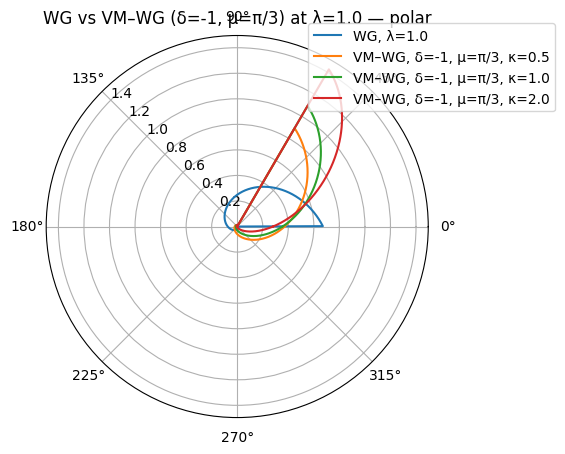

['vmwg_reflection_linear_kappa0.5.png',
 'vmwg_reflection_linear_kappa0.5.pdf',
 'vmwg_reflection_polar_kappa0.5.png',
 'vmwg_reflection_polar_kappa0.5.pdf',
 'vmwg_reflection_linear_kappa1.0.png',
 'vmwg_reflection_linear_kappa1.0.pdf',
 'vmwg_reflection_polar_kappa1.0.png',
 'vmwg_reflection_polar_kappa1.0.pdf',
 'vmwg_reflection_linear_kappa2.0.png',
 'vmwg_reflection_linear_kappa2.0.pdf',
 'vmwg_reflection_polar_kappa2.0.png',
 'vmwg_reflection_polar_kappa2.0.pdf',
 'compare_wg_vmwg_reflection_linear_lambda1.png',
 'compare_wg_vmwg_reflection_linear_lambda1.pdf']

In [5]:
# Generate VM–WG plots with reflection (delta = -1) and user-chosen mu (mu_user).
# Also include WG vs VM–WG comparisons under reflection.
import numpy as np
import matplotlib.pyplot as plt

two_pi = 2.0*np.pi

def wrap_angle(x):
    return x - two_pi*np.floor(x/two_pi)

def f_garima(x, lam):
    y = np.zeros_like(x, dtype=float)
    mask = x > 0
    y[mask] = (lam/(lam+2.0))*(1.0 + lam + lam*x[mask]) * np.exp(-lam*x[mask])
    return y

def dWG(theta_vals, lam, tol=1e-12, M_max=500):
    theta_vals = wrap_angle(theta_vals)
    out = np.zeros_like(theta_vals, dtype=float)
    for i, th in enumerate(theta_vals):
        s = 0.0
        m = 0
        term = np.inf
        while m < M_max and (m == 0 or term > tol):
            t = th + two_pi*m
            term = f_garima(np.array([t]), lam)[0]
            s += term
            m += 1
        out[i] = s
    return out

def periodic_interp(x_grid, y_grid, xq):
    x_ext = np.concatenate([x_grid, np.array([two_pi])])
    y_ext = np.concatenate([y_grid, np.array([y_grid[0]])])
    xq_wrapped = wrap_angle(xq)
    return np.interp(xq_wrapped, x_ext, y_ext)

def vmwg_unnormalized(theta_grid, lam, kappa, mu=0.0, delta=1, gWG_grid=None):
    phi = wrap_angle(delta*(theta_grid - mu))
    if gWG_grid is None:
        g_phi = dWG(phi, lam)
    else:
        g_phi = periodic_interp(theta_grid, gWG_grid, phi)
    return g_phi * np.exp(kappa*np.cos(theta_grid - mu))

def Z_numeric(theta_grid, gWG_grid, kappa):
    integrand = gWG_grid * np.exp(kappa*np.cos(theta_grid))
    dtheta = theta_grid[1] - theta_grid[0]
    return np.trapz(integrand, dx=dtheta)

# Parameters and grids
lambdas = [0.5, 1.0, 2.0]
kappas  = [0.5, 1.0, 2.0]   # positive kappas for comparison (kappa=0 reduces to WG under shift/flip)
delta   = -1                # reflection requested
mu_user = np.pi/3           # user-chosen μ (e.g., sample mean direction)

N = 1440
theta = np.linspace(0.0, two_pi, N, endpoint=False)

# Precompute WG on grid and Z(λ, κ) (independent of μ, δ)
gWG_by_lam = {}
Z_by_lam_kappa = {}
for lam in lambdas:
    g = dWG(theta, lam)
    gWG_by_lam[lam] = g
    for kap in kappas:
        Z_by_lam_kappa[(lam, kap)] = Z_numeric(theta, g, kap)

files = []

# 1) VM–WG with reflection and user μ: overlays across λ for each κ (linear and polar)
for kap in kappas:
    # linear
    plt.figure(figsize=(8, 4.6))
    for lam in lambdas:
        g = gWG_by_lam[lam]
        num = vmwg_unnormalized(theta, lam, kap, mu=mu_user, delta=delta, gWG_grid=g)
        dens = num / Z_by_lam_kappa[(lam, kap)]
        plt.plot(theta, dens, label=f"λ={lam}, κ={kap}")
    plt.xlabel("θ (radians)")
    plt.ylabel("Density")
    plt.title(f"VM–WG (reflection δ=-1, μ=π/3) — linear view")
    plt.legend()
    plt.tight_layout()
    fn_png = f"vmwg_reflection_linear_kappa{kap}.png"
    fn_pdf = f"vmwg_reflection_linear_kappa{kap}.pdf"
    plt.savefig(fn_png, dpi=200, bbox_inches="tight")
    plt.savefig(fn_pdf, bbox_inches="tight")
    plt.show()
    plt.close()
    files += [fn_png, fn_pdf]

    # polar
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, projection='polar')
    for lam in lambdas:
        g = gWG_by_lam[lam]
        num = vmwg_unnormalized(theta, lam, kap, mu=mu_user, delta=delta, gWG_grid=g)
        dens = num / Z_by_lam_kappa[(lam, kap)]
        ax.plot(theta, dens, label=f"λ={lam}, κ={kap}")
    ax.set_title("VM–WG (δ=-1, μ=π/3) — polar view", va='bottom')
    ax.set_rlabel_position(135)
    ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.05))
    plt.tight_layout()
    fn_png = f"vmwg_reflection_polar_kappa{kap}.png"
    fn_pdf = f"vmwg_reflection_polar_kappa{kap}.pdf"
    plt.savefig(fn_png, dpi=200, bbox_inches="tight")
    plt.savefig(fn_pdf, bbox_inches="tight")
    plt.show()
    plt.close()
    files += [fn_png, fn_pdf]

# 2) WG vs VM–WG under reflection at λ=1.0, multiple κ
lam_demo = 1.0
g_demo = gWG_by_lam[lam_demo]

# linear comparison
plt.figure(figsize=(8, 4.6))
plt.plot(theta, g_demo, label=f"WG, λ={lam_demo}")
for kap in kappas:
    num = vmwg_unnormalized(theta, lam_demo, kap, mu=mu_user, delta=delta, gWG_grid=g_demo)
    dens = num / Z_by_lam_kappa[(lam_demo, kap)]
    plt.plot(theta, dens, label=f"VM–WG, δ=-1, μ=π/3, κ={kap}")
plt.xlabel("θ (radians)")
plt.ylabel("Density")
plt.title(f"WG vs VM–WG (δ=-1, μ=π/3) at λ={lam_demo} — linear")
plt.legend()
plt.tight_layout()
cmp_ref_lin_png = "compare_wg_vmwg_reflection_linear_lambda1.png"
cmp_ref_lin_pdf = "compare_wg_vmwg_reflection_linear_lambda1.pdf"
plt.savefig(cmp_ref_lin_png, dpi=200, bbox_inches="tight")
plt.savefig(cmp_ref_lin_pdf, bbox_inches="tight")
plt.show()
plt.close()
files += [cmp_ref_lin_png, cmp_ref_lin_pdf]

# polar comparison
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection='polar')
ax.plot(theta, g_demo, label=f"WG, λ={lam_demo}")
for kap in kappas:
    num = vmwg_unnormalized(theta, lam_demo, kap, mu=mu_user, delta=delta, gWG_grid=g_demo)
    dens = num / Z_by_lam_kappa[(lam_demo, kap)]
    ax.plot(theta, dens, label=f"VM–WG, δ=-1, μ=π/3, κ={kap}")
ax.set_title(f"WG vs VM–WG (δ=-1, μ=π/3) at λ={lam_demo} — polar", va='bottom')
ax.set_rlabel_position(135)
ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.05))
plt.tight_layout()
cmp_ref_pol_png = "compare_wg_vmwg_reflection_polar_lambda1.png"
cmp_ref_pol_pdf = "compare_wg_vmwg_reflection_polar_lambda1.pdf"
plt.savefig(cmp_ref_pol_png, dpi=200, bbox_inches="tight")
plt.savefig(cmp_ref_pol_pdf, bbox_inches="tight")
plt.show()
plt.close()
files
